***Peer-graded Assignment: Segmenting and Clustering Neighborhoods in TorontoPeer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto***

**Part 1:**

Install libraries

In [1]:
! pip install lxml

In [2]:
! pip install BeautifulSoup4

In [3]:
! pip install shapely

In [4]:
! pip install geopandas

In [5]:
import numpy as np 
import pandas as pd
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request

from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns


Scanning input data

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'html.parser')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Preparing input data

In [7]:
# Ignore cells with a borough that is Not assigned
selected_data = data[data['Borough'] != 'Not assigned']
# Grouping
selected_data = selected_data.groupby(['Postal Code','Borough'], as_index=False).agg(','.join)
selected_data.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
#Replacing values in Neighbourhood field with Borough where Neighbourhood is not assigned
selected_data['Neighbourhood'] = np.where(selected_data['Neighbourhood'] == 'Not assigned', selected_data['Borough'], selected_data['Neighbourhood'])

#Shape of the final output data
selected_data.shape

(103, 3)

**Part2:**

Read the CVS-file

In [9]:
geospatial_data = pd.read_csv('https://cocl.us/Geospatial_data')
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Preparing input data

In [10]:
# Rename the columns
geospatial_data.columns = ['Postal Code', 'Latitude', 'Longitude']
geospatial_data.columns

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

In [11]:
#Merge dataframes
merged_data = pd.merge(selected_data, geospatial_data, on= 'Postal Code')

In [12]:
merged_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Part3:**

In [13]:
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))

In [14]:
merged_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"(43.806686299999996, -79.19435340000001)"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,"(43.7845351, -79.16049709999999)"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"(43.7635726, -79.1887115)"
3,M1G,Scarborough,Woburn,43.770992,-79.216917,"(43.7709921, -79.21691740000001)"
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,"(43.773136, -79.23947609999999)"


In [15]:
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')
gdf.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Coordinates
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,POINT (43.80669 -79.19435)
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,POINT (43.78454 -79.16050)
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,POINT (43.76357 -79.18871)
3,M1G,Scarborough,Woburn,43.770992,-79.216917,POINT (43.77099 -79.21692)
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,POINT (43.77314 -79.23948)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


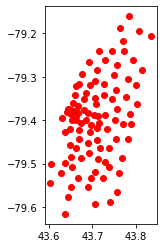

In [16]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black')
# plot and show the final data
gdf.plot(ax=ax, color='red')

plt.show()